# Randomized Benchmarking: Unitarity RB

## Background

In this notebook we explore the subset of methods in `randomized_benchmarking.py` that are related specifically to unitarity randomized benchmarking. I suggest reviewing the [notebook](randomized_benchmarking.ipynb) `examples/randomized_benchmarking.ipynb` first, since we will assume familiarity with its contents and treat unitarity as a modification to the 'standard' RB protocol.

In standard RB we are interested in characterizing the average impact of noise on our gates, and we estimate an average error rate per Clifford. Unitarity RB is designed to characterize this noise further. There are two different types of noise that impact the quality of a target operation

- coherent, or unitary, noise which can arise from imperfect control or improper calibration such that the resulting operation is unitary but different from the target gate. For example, an extreme case of coherent error would be implementing a perfect X gate when trying to perform a target Z gate. A more common and insidious case of coherent noise is an over or under rotation, e.g. performing RX(pi + .001) for a target RX(pi) gate. 

- incoherent noise makes the overall operation non-unitary and can rotate the affected state out of the computational subspace into the larger system + environment space through unwanted interaction with the environment. For a single qubit state represented on the [Bloch sphere](https://en.wikipedia.org/wiki/Bloch_sphere) this has the affect of moving the state vector closer to the center of the sphere. The [depolarizing channel](https://en.wikipedia.org/wiki/Quantum_depolarizing_channel) is the archetype of incoherent error which in the single qubit case shrinks the surface of the Bloch sphere uniformly to the central point. [Amplitude damping](https://en.wikipedia.org/wiki/Amplitude_damping_channel) is another example, where for a single qubit the surface of the Bloch sphere shrinks to the $|0 \rangle$ state pole.

The unitarity measurement is meant to provide an estimate of how coherent the noise is. Already in describing the examples we see that the two different types of noise affect states in different ways. Focusing on the Bloch sphere representation for single qubit states, fully coherent (unitary) noise rotates the surface of the sphere just like any other unitary operation; meanwhile, incoherent noise shrinks the volume of the sphere and, in general, translates its center. We will use the difference between these two actions on various states to characterize the noise. Just as in RB we will estimate the average of some quantity (the shifted purity) over groups of random sequences of Clifford gates of increasing depth, fit an exponential decay curve, and extract an estimate of the base decay constant. In this case, the decay constant is dubbed 'unitarity' and takes on a value between 0 and 1 inclusive. Purely coherent noise--as in the case of an extraneous unitary gate--yields a unitarity of 1 whereas purely incoherent noise--such as the depolarizing channel--yields a unitarity of 0.

### Purity

The [purity](https://en.wikipedia.org/wiki/Purity_%28quantum_mechanics%29) $p$ of a quantum state $\rho$ is defined as

$$p(\rho) = tr(\rho^2)$$

The set of pure single qubit states, that is with $p=1$, is precisely the set of states which comprise the surface of the Bloch sphere. Indeed, we can relate the purity of a state to the length of the state vector in the generalized Bloch sphere. Using a complete operator basis such as the [pauli basis](https://en.wikipedia.org/wiki/Pauli_matrices) we can expand any $d$-dimensional quantum state $\rho$ as a linear combination over basis matrices:

$$\rho = (I + \sum_k n_k \sigma_k) / d = (I + \sum_k tr[\rho \sigma_k] \sigma_k)/d$$

where we have denoted the traceless pauli matrices by $\{\sigma_k\}$. Here we see that the purity is given as 

$$p = tr(\rho^2) = 1/d + ||\vec n||^2/d$$

where $\vec n = (n_1, n_2, \dots, n_{d-1})$ is the Bloch vector. The purity for quantum states lays in the interval $[1/d, 1]$. Following [ECN] we define a shifted (or normalized) purity bounded between 0 and 1:

$$p' = \frac{d (p - 1 / d)}{d-1} = ||\vec n||^2/(d-1)$$

Combining all of the observations above, we expect that the shifted purity $p'$ of an initially pure state under the action of incoherent noise such as repeated applications of a depolarizing channel will decay from 1 to 0 over the course of many applications as the Bloch vector shrinks to the origin. Indeed, it is the shifted purity that replaces the survival probability from standard RB. To estimate the purity we take the expectation of each traceless pauli operator $\sigma_k$ measured on a given sequence. 

### The protocol

There are two differences between unitarity and RB. First and foremost, we estimate the purity of each sequence rather than the survival probability. Secondly, we don't need the sequence of Cliffords to be self-inverting. Hence the procedure is summarized as

- Select some set of depths over which you expect the survival probability to decay significantly

- Generate many random sequences for each depth. A random sequence is simply depth-many uniform random Clifford elements.

- Estimate the 'shifted purity' for each sequence estimating the expectation of each traceless Pauli observable after running the sequence; the `ObservablesExperiment` framework is used heavily here. 

- Fit an exponential decay model to the estimated shifted purities. 

- Extract the decay parameter (unitarity) from the fit. From this we can get an upper bound on the standard RB decay. If the noise channel is a depolarizing channel then this upper bound is saturated. 

For more information, including a formal definition of unitarity, see


| [ECN] *Estimating the Coherence of Noise*.  
|     Wallman et al.  
|     New Journal of Physics 17, 113020 (2015).  
|     https://dx.doi.org/10.1088/1367-2630/17/11/113020  
|     https://arxiv.org/abs/1503.07865  


We also make use of unitarity in the [notebook](randomized_benchmarking_interleaved.ipynb) `examples/randomized_benchmarking_interleaved.ipynb` 

## The code

The basics mirror standard RB. We use the same basic setup and functions with slight name changes. 

In [1]:
# Needs in terminal:
# $ quilc -S
# $ qvm -S

import numpy as np
from forest.benchmarking.plotting import plot_figure_for_fit
from forest.benchmarking.randomized_benchmarking import *

from pyquil.api import get_benchmarker
from pyquil import Program, get_qc

noisy_qc = get_qc('2q-qvm', noisy=True)
bm = get_benchmarker()

Since we are estimating many more observables for each sequence than standard RB this will take longer.

By default all the observables on each sequence are grouped so that compatible observables are estimated simultaneously from the same set of measurements. This speeds up data acquisition. The number of observables being estimated scales as the square of the size of the largest qubit group.

100%|██████████| 200/200 [01:43<00:00,  1.93it/s]


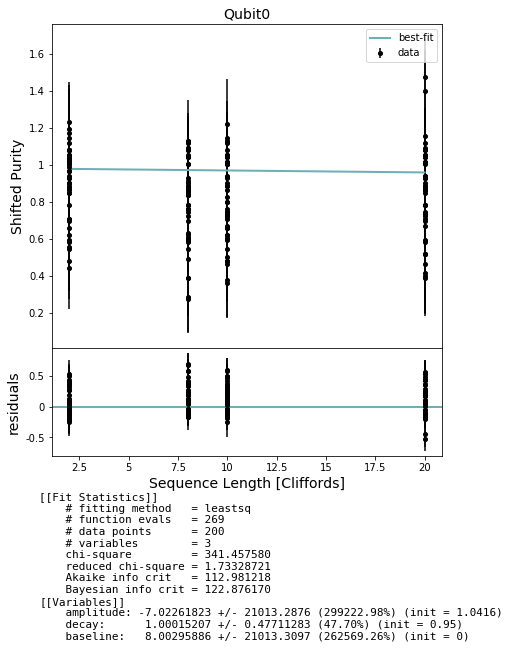

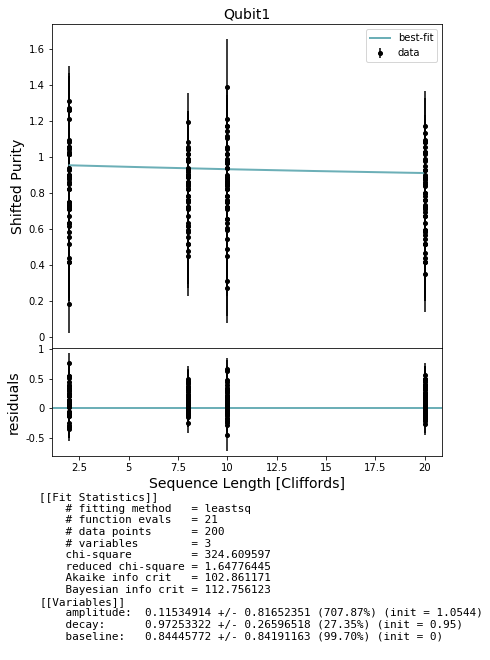

In [2]:
# THIS IS SLOW (around a minute). The below comment skips this cell during testing. Please do not remove.
# NBVAL_SKIP
num_sequences_per_depth = 50
num_shots = 25

# select groups of qubits. Here we choose to simultaneously run two 
# single qubit experiments on qubit 0 and qubit 1
qubit_groups = [(0,), (1,)]
depths = [2, 8, 10, 20]
depths = [d for d in depths for _ in range(num_sequences_per_depth)]

expts = generate_unitarity_experiments(bm, qubit_groups, depths)

results = acquire_rb_data(noisy_qc, expts, num_shots, show_progress_bar=True)
stats_by_group = get_stats_by_qubit_group(qubit_groups, results)
fits = []
for group in qubit_groups:
    stats = stats_by_group[group]
    fit = fit_unitarity_results(depths, stats['expectation'], stats['std_err'])
    fits.append(fit)
    fig, axs = plot_figure_for_fit(fit, xlabel="Sequence Length [Cliffords]", ylabel="Shifted Purity", 
                       title='Qubit' + str(group[0]))

The default qvm noise model doesn't produce a nice curve. We'll fix this below.

## Advanced functionality: inserting simple-to-analyze noise

In [3]:
from pyquil import noise

def add_noise_to_sequences(sequences, qubits, kraus_ops):
    """
    Append the given noise to each clifford gate (sequence)
    """
    for seq in sequences:
        for program in seq:
            program.defgate("noise", np.eye(2 ** len(qubits)))
            program.define_noisy_gate("noise", qubits, kraus_ops)
            program.inst(("noise", *qubits))
    
def depolarizing_noise(num_qubits: int, p: float =.95):
    """
    Generate the Kraus operators corresponding to a given unitary
    single qubit gate followed by a depolarizing noise channel.

    :params float num_qubits: either 1 or 2 qubit channel supported
    :params float p: parameter in depolarizing channel as defined by: p $\rho$ + (1-p)/d I
    :return: A list, eg. [k0, k1, k2, k3], of the Kraus operators that parametrize the map.
    :rtype: list
    """
    num_of_operators = 4**num_qubits
    probabilities = [p+(1.0-p)/num_of_operators] + [(1.0 - p)/num_of_operators]*(num_of_operators-1)
    return noise.pauli_kraus_map(probabilities)

# get a qc without any noise
quiet_qc = get_qc('1q-qvm', noisy=False)

A depolarizing channel applied to each Clifford is especially simple to analyze. In particular, we expect to be able to convert the estimated unitarity to the RB decay parameter which parameterizes the channel. 

To insert the noise we have to use the individual parts that make up `generate_unitarity_experiments`, similar to what we did in the advanced section for standard RB. 

100%|██████████| 200/200 [01:03<00:00,  3.16it/s]


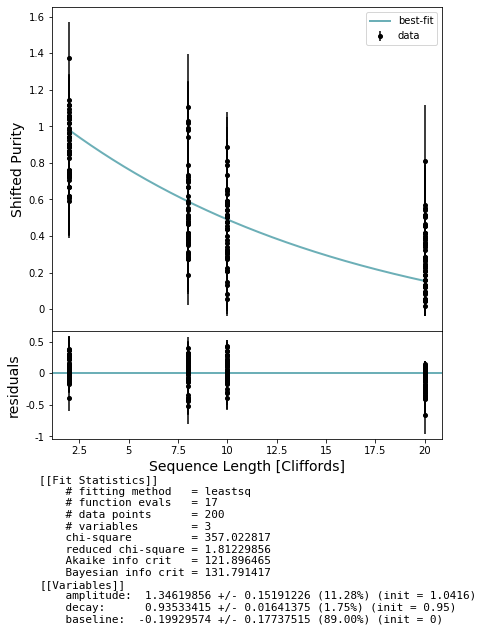

In [4]:
# This is also SLOW
qubits = (0,)

single_clifford_p = .95 #p parameter for the depolarizing channel applied to each clifford
kraus_ops = depolarizing_noise(len(qubits), single_clifford_p)


depths = [2, 8, 10, 20]
depths = [d for d in depths for _ in range(num_sequences_per_depth)]


sequences = generate_rb_experiment_sequences(bm, qubits, depths, use_self_inv_seqs=False)

# insert our custom noise
add_noise_to_sequences(sequences, qubits, kraus_ops)

expts = group_sequences_into_parallel_experiments([sequences], [qubits], is_unitarity_expt=True)

results = acquire_rb_data(quiet_qc, expts, num_shots, show_progress_bar=True)

stats = get_stats_by_qubit_group([qubits], results)[qubits]
fit = fit_unitarity_results(depths, stats['expectation'], stats['std_err'])

# plot the raw data, point estimate error bars, and fit
fig, axs = plot_figure_for_fit(fit, xlabel="Sequence Length [Cliffords]", ylabel="Shifted Purity")

In [5]:
unitarity = fit.params['decay'].value
print(unitarity)
err = fit.params['decay'].stderr
print(err)

0.9353341455250523
0.016413752007987215


Since the noise is depolarizing, we expect `unitarity_to_rb_decay(unitarity)` to match the input noise parameter `single_clifford_p = .95` up to the error in our estimate.

In [6]:
from forest.benchmarking.randomized_benchmarking import unitarity_to_rb_decay

print(f'{unitarity_to_rb_decay(unitarity-err, 2)} '\
      f'<? {single_clifford_p} '\
      f'<? {unitarity_to_rb_decay(unitarity+err, 2)}')

0.9586033556779703 <? 0.95 <? 0.9755756749391815
